# Solving LP and QP with CVXPY

# https://www.cvxpy.org

CVXPY relies on the open source solvers ECOS, OSQP, and SCS. Additional solvers are supported, but must be installed separately. 

# Functions and operators: 
### - .T transpose
### - @ matrix-vector or vector-vector multiplication
### - quad_form(x,P) $x^TPx$
### - matrix_frac(x, P) $x^TP^{-1}x$

### https://www.cvxpy.org/tutorial/functions/index.html

### Import packages.

In [2]:
# For osx users, make sure you have developer tools installed
# xcode-select --install

xcode-select: note: install requested for command line developer tools


In [3]:
import cvxpy as cp
import numpy as np

In [4]:
A = np.array([[0, 1],
     [1, 0]])
b = np.array([1, 2])

In [8]:
# A @ b

# Linear Programming

\begin{align} 
\text{minimize } &c^Tx\\
\text{subject to } &Ax\leq b
\end{align}

### Generate a random non-trivial linear program.

In [21]:
m = 15
n = 10
np.random.seed(1)
s0 = np.random.randn(m)
lamb0 = np.maximum(-s0, 0)
s0 = np.maximum(s0, 0)
x0 = np.random.randn(n)
A = np.random.randn(m, n)
b = A @ x0 + s0
c = -A.T @ lamb0

### Define and solve the CVXPY problem.

In [22]:
x = cp.Variable(n)
prob = cp.Problem(cp.Minimize(c.T @ x), [A @ x <= b])
prob.solve()

-15.220912604449774

### Print result.

In [23]:
print("\nThe optimal value is", prob.value)
print("A solution x is")
print(x.value)
print("A dual solution is")
print(prob.constraints[0].dual_value)


The optimal value is -15.220912604449774
A solution x is
[-1.09462326 -0.20466376 -0.80667962  0.07890685  0.49481543 -1.0047415
  1.19966687  0.97398692  0.54537495  0.90952462]
A dual solution is
[1.27313592e-13 6.11756414e-01 5.28171752e-01 1.07296862e+00
 5.97228032e-13 2.30153870e+00 2.13913306e-13 7.61206901e-01
 8.20205732e-12 2.49370375e-01 1.40387338e-13 2.06014071e+00
 3.22417204e-01 3.84054355e-01 3.10002354e-12]


# Quadratic Program.

\begin{align} 
\text{minimize } &\frac{1}{2}x^TPx + q^Tx \\
\text{subject to } &Gx\leq h \\
                    &Ax= b
\end{align}

### Generate a random non-trivial quadratic program.

In [42]:
m = 15
n = 10
p = 5
np.random.seed(1)
P = np.random.randn(n, n)
P = P.T @ P
q = np.random.randn(n)
G = np.random.randn(m, n)
h = G @ np.random.randn(n)
A = np.random.randn(p, n)
b = np.random.randn(p)

### Define and solve the CVXPY problem.

In [59]:
x = cp.Variable(n)
obj = (1/2) * cp.quad_form(x, P) + q.T @ x
prob = cp.Problem(cp.Minimize(obj),
                    [G @ x <= h,
                     A @ x == b])

In [60]:
prob.solve()

86.89141585569912

### Print result.

In [48]:
print("\nThe optimal value is", prob.value)
print("A solution x is")
print(x.value)
print("A dual solution corresponding to the inequality constraints is")
print(prob.constraints[0].dual_value)
print(prob.constraints[1].dual_value)



The optimal value is 86.89141585569912
A solution x is
[-1.68244521  0.29769913 -2.38772183 -2.79986015  1.18270433 -0.20911897
 -4.50993526  3.76683701 -0.45770675 -3.78589638]
A dual solution corresponding to the inequality constraints is
[ 0.          0.          0.          0.          0.         10.45538054
  0.          0.          0.         39.67365045  0.          0.
  0.         20.79927156  6.54115873]
[-4.00594325  0.67788482 36.2406246  18.40408038 27.97777688]


In [50]:
print(prob.solution.primal_vars)

{417: array([-1.68244521,  0.29769913, -2.38772183, -2.79986015,  1.18270433,
       -0.20911897, -4.50993526,  3.76683701, -0.45770675, -3.78589638])}


# Regression 

In [68]:
%matplotlib inline
import matplotlib.pyplot as plt
np.random.seed(5)

### Initialize some data with gaussian random noise

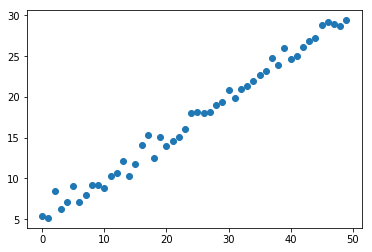

In [69]:
x = np.arange(50)
y = 0.5 * x + 5 + np.random.standard_normal(50)
plt.scatter(x, y)

 $$\text{minimize}_{w,b} \sum_{i=1}^n (w * x_i + b - y_i)^2$$

### Perturb it!

In [7]:
for i in range(40):
    if np.random.random() < 0.1:
        y[i] += 10
plt.scatter(x, y)

### Try linear regression

In [73]:
# P = np.random.normal((50,50))
w = cp.Variable()
b = cp.Variable()
obj = 0
for i in range(50):
    obj += (w * x[i] + b - y[i]) ** 2
# cp.Problem(cp.Minimize(obj), [cp.quad_form(x,np.eye(n)) == 1]).solve()
w = w.value
b = b.value

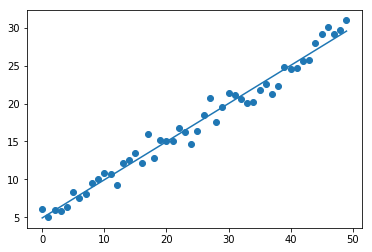

In [65]:
plt.scatter(x,y)
plt.plot(x, x * w + b)

# Disciplined Convex Programming
### https://dcp.stanford.edu/rules
Disciplined convex programming (DCP) is a system for constructing mathematical expressions with known curvature from a given library of base functions. 
- CVXPY uses DCP to ensure that the specified optimization problems are convex.  DCP analysis is based on applying a general composition theorem from convex analysis to each (sub)expression.

# Control

Convex optimization can be used to solve many problems that arise in control.
In this example we show how to solve such a problem using CVXPY.
We have a system with a state $x_t\in {\bf R}^n$ that varies over the time steps $t=0,\ldots,T$, and inputs or actions $u_t\in {\bf R}^m$ we can use at each time step to affect the state.
For example, $x_t$ might be the position and velocity of a rocket and $u_t$ the output of the rocket's thrusters.
We model the evolution of the state as a linear dynamical system, i.e.,

$$ x_{t+1} = Ax_t + Bu_t $$

where $A \in {\bf R}^{n\times n}$ and $B \in {\bf R}^{n\times m}$ are known matrices.

Our goal is to find the optimal actions $u_0,\ldots,u_{T-1}$ by solving the optimization problems

\begin{array}{ll} \mbox{minimize} & \sum_{t=0}^{T-1} \ell (x_t,u_t) + \ell_T(x_T)\\
\mbox{subject to} & x_{t+1} = Ax_t + Bu_t\\%, \quad t=0, \ldots, T-1\\
& (x_t,u_t) \in \mathcal C, \quad x_T\in \mathcal C_T,
%, \quad \quad t=0, \ldots, T
\end{array}

where $\ell: {\bf R}^n \times {\bf R}^m\to {\bf R}$ is the stage cost, $\ell_T$ is the terminal cost,
$\mathcal C$ is the state/action constraints, and $\mathcal C_T$ is the terminal constraint.
The optimization problem is convex if the costs and constraints are convex.


### Example

In the following code we solve a control problem with $n=8$ states, $m=2$ inputs, and horizon $T=50$.
The matrices $A$ and $B$ and the initial state $x_0$ are randomly chosen (with $A\approx I$).
We use the (traditional) stage cost $\ell(x,u) = \|x\|_2^2 + \|u\|_2^2$, the input constraint $\|u_t\|_\infty \leq 1$, and the terminal constraint $x_{T}=0$.



In [ ]:
# Generate data for control problem.
import numpy as np
np.random.seed(1)
n = 8
m = 2
T = 50
alpha = 0.2
beta = 5
A = np.eye(n) + alpha*np.random.randn(n,n)
B = np.random.randn(n,m)
x_0 = beta*np.random.randn(n)



In [ ]:
# Form and solve control problem.
import cvxpy as cp


In [ ]:
# Plot results.
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

f = plt.figure()

# Plot (u_t)_1.
ax = f.add_subplot(411)
plt.plot(u[0,:].value)
plt.ylabel(r"$(u_t)_1$", fontsize=16)
plt.yticks(np.linspace(-1.0, 1.0, 3))
plt.xticks([])

# Plot (u_t)_2.
plt.subplot(4,1,2)
plt.plot(u[1,:].value)
plt.ylabel(r"$(u_t)_2$", fontsize=16)
plt.yticks(np.linspace(-1, 1, 3))
plt.xticks([])

# Plot (x_t)_1.
plt.subplot(4,1,3)
x1 = x[0,:].value
plt.plot(x1)
plt.ylabel(r"$(x_t)_1$", fontsize=16)
plt.yticks([-10, 0, 10])
plt.ylim([-10, 10])
plt.xticks([])

# Plot (x_t)_2.
plt.subplot(4,1,4)
x2 = x[1,:].value
plt.plot(range(51), x2)
plt.yticks([-25, 0, 25])
plt.ylim([-25, 25])
plt.ylabel(r"$(x_t)_2$", fontsize=16)
plt.xlabel(r"$t$", fontsize=16)
plt.tight_layout()
plt.show()